# NOTEBOOK FOR SURFACE TRAP

In [1]:
import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import sinsquared
from pytrans.solver import solver, init_waveform

/home/kallo27/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 04/2023
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


# trap geometry parameters
um = 1e-6
rf_width = 120 * um
rf_sep = 60 * um

n_dc_lines = 5
dc_width = 100 * um

dc_length = 1300 * um
trap_length = 3000 * um

filename = "surface_trap_geometry.json"

corners = {}

corners['DCintop'] = (-trap_length / 2, trap_length / 2, 0, rf_sep / 2)
corners['DCinbot'] = (-trap_length / 2, trap_length / 2, -rf_sep / 2, 0)

dc_edges = [
    (dc_width * (j - n_dc_lines / 2), dc_width * (j + 1 - n_dc_lines / 2))
    for j in range(n_dc_lines)
]

corners.update({
    f"DCtop{j + 1}": dc_edges[j] + ((rf_sep / 2 + rf_width), (rf_sep / 2 + rf_width + dc_length))
    for j in range(n_dc_lines)
})

corners.update({
    f"DCbot{j + 1}": dc_edges[j] + (-(rf_sep / 2 + rf_width + dc_length), -(rf_sep / 2 + rf_width))
    for j in range(n_dc_lines)
})


def ring_from_corners(corners):
    x1, x2, y1, y2 = map(lambda x: x / um, corners)
    ring = [[x1, y1], [x2, y1], [x2, y2], [x1, y2], [x1, y1]]
    return ring


#if __name__ == '__main__':
#    import json
#    import matplotlib.pyplot as plt
#    from matplotlib.path import Path
#    from matplotlib.patches import PathPatch
#
#    json_geometry = {name: [ring_from_corners(_corners)] for name, _corners in corners.items()}
#
#    rf_bot_corners = (-trap_length / 2, trap_length / 2, -(rf_sep / 2 + rf_width), -rf_sep / 2)
#    rf_top_corners = (-trap_length / 2, trap_length / 2, rf_sep / 2, (rf_sep / 2 + rf_width))
#
#    json_geometry["RF"] = [ring_from_corners(rf_bot_corners) + ring_from_corners(rf_top_corners)]
#
#    print(json_geometry.keys())
#    with open(filename, 'w') as f:
#        json.dump(json_geometry, f, indent=2)
#
#    fig, ax = plt.subplots()
#    for name, ele in json_geometry.items():
#        path = Path.make_compound_path(*[Path(ring) for ring in ele])
#        patch = PathPatch(path, linewidth=1, facecolor='none')
#        ax.add_patch(patch)
#
#    ax.relim()
#    ax.autoscale_view()
#
#    plt.show()


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Created: 01-2021 - Carmelo Mordini <carmelo> <cmordini@phys.ethz.ch>

import numpy as np
from pytrans.electrode import DCElectrode, RFElectrode
from pytrans.abstract_model import AbstractTrapModel
from rectset import rectangle_electrode as rect, pseudopotential as ps

import logging
logger = logging.getLogger(__name__)

_DC_ELECTRODES = [
    "DCintop", "DCinbot",
    "DCtop1", "DCtop2", "DCtop3", "DCtop4", "DCtop5",
    "DCbot1", "DCbot2", "DCbot3", "DCbot4", "DCbot5",
]


class SurfaceTrapDCElectrode(DCElectrode):

    def __init__(self, name):
        self._corners = corners[name]
        super().__init__()

    def _unit_potential(self, x, y, z):
        return rect.rect_el_potential(x, y, z, *self._corners)

    def _unit_gradient(self, x, y, z):
        return rect.rect_el_gradient(x, y, z, *self._corners)

    def _unit_hessian(self, x, y, z):
        return rect.rect_el_hessian(x, y, z, *self._corners)


class SurfaceTrapRFElectrode(RFElectrode):

    def _unit_potential(self, x, y, z):
        return ps.pseudo_potential(x, y, z, rf_sep, rf_width)

    def _unit_gradient(self, x, y, z):
        return ps.pseudo_gradient(x, y, z, rf_sep, rf_width)

    def _unit_hessian(self, x, y, z):
        return ps.pseudo_hessian(x, y, z, rf_sep, rf_width)


class SurfaceTrap(AbstractTrapModel):

    _dc_electrodes = {name: SurfaceTrapDCElectrode(name) for name in _DC_ELECTRODES}
    _rf_electrodes = {"RF": SurfaceTrapRFElectrode()}
    _rf_voltage = 40
    _rf_freq_mhz = 20

    # Extra attributes and methods to enrich the model
    w_ele = dc_width
    x = np.arange(-250, 251, 0.5) * 1e-6
    y0 = 0.0
    z0 = ps.rf_null_z(rf_sep, rf_width)
    rf_null_coords = (None, y0, z0)
    dt = 392e-9

    @classmethod
    def x_ele(cls, j):
        # center position of electrode j
        # j = 1 .. 2
        return cls.w_ele * (j - 3)


In [8]:
trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = 50
x = sinsquared(trap.x_ele(2), trap.x_ele(4), n_samples)
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
    # obj.SlewRateObjective(waveform, value=4e6, dt=trap.dt, constraint_type='<=')  # V/s
]

solver_results = solver(objectives, verbose=True, solver="ECOS")
waveform = solver_results.waveform.value  # get array from cvxpy variable

#savename = data_dir / 'waveform_transport.npy'
#print(f"Saving waveform as ndarray to {savename}")
#np.save(savename, waveform)


Compiling objectives:   0%|          | 0/154 [00:00<?, ?it/s]

Compiling objectives: 100%|██████████| 154/154 [00:01<00:00, 108.88it/s]

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 20 04:20:03 PM: Your problem has 600 variables, 1200 constraints, and 0 parameters.


(CVXPY) Feb 20 04:20:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 20 04:20:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 20 04:20:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 20 04:20:03 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 20 04:20:03 PM: Compiling problem (target solver=ECOS).
(CVXPY) Feb 20 04:20:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Feb 20 04:20:03 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 20 04:20:03 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 20 04:20:03 PM: Applying

/home/kallo27/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


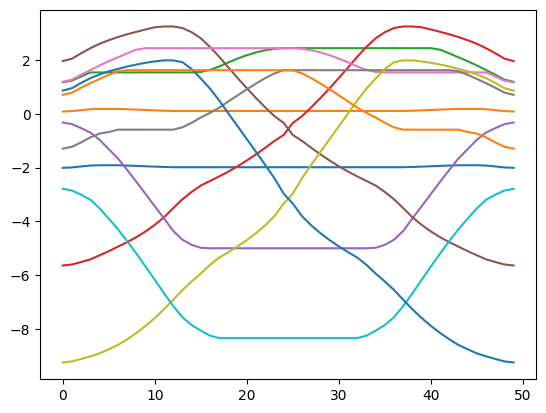

In [9]:
import matplotlib.pyplot as plt
plt.plot(waveform)

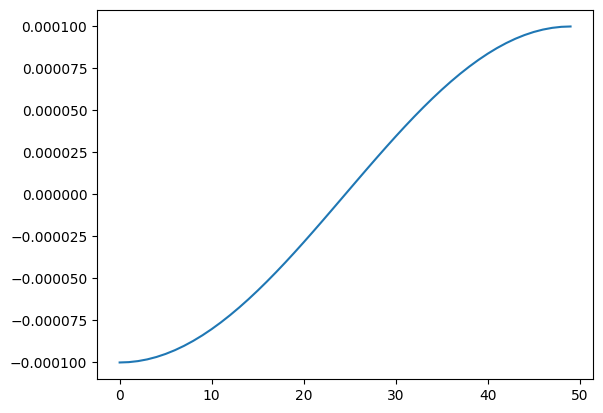

In [10]:
plt.plot(x)

In [70]:
import re

timestamp = "20250220_233845"

file_path = f'./QuOCS_Results/{timestamp}_OptimalControldCRAB/{timestamp}_logging.log'
with open(file_path, 'r') as file:
    # Create a list to store FoM values
    fomlist = []

    # Read each line in the log file
    for line in file:
        # Search for lines that contain "FoM" and extract the FoM value
        match = re.search(r'FoM:\s([0-9\.]+)', line)
        if match:
            fomlist.append(float(match.group(1)))

In [71]:
import zipfile

file_path = f'./QuOCS_Results/{timestamp}_OptimalControldCRAB/{timestamp}_best_controls.npz'
# Open the .apz file as a ZIP archive
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # List all files inside the archive
    file_names = zip_ref.namelist()
    print("Files inside the archive:", file_names)

    with zip_ref.open('time_grid_for_Pulse_1.npy') as time_file:
      timegrid = np.load(time_file)
    with zip_ref.open('Pulse_1.npy') as file:
      pulse = np.load(file)

Files inside the archive: ['Pulse_1.npy', 'time_grid_for_Pulse_1.npy', 'pulse_names.npy', 'parameter_names.npy', 'time_names.npy', 'FoM.npy', 'iteration_number.npy', 'super_it.npy', 'status_code.npy']


Text(0, 0.5, 'Amplitude')

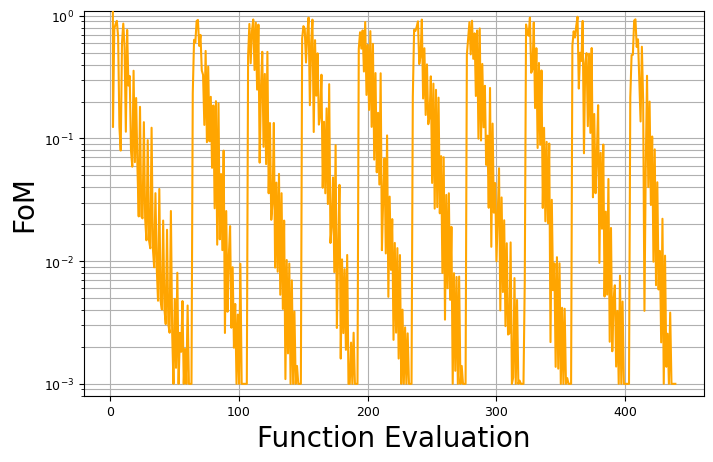

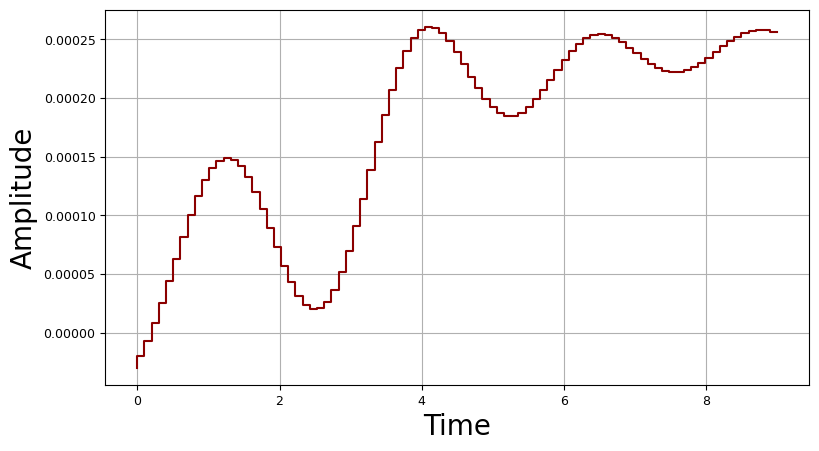

In [72]:
import matplotlib.pyplot as plt
# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax.set_yscale("log")
plt.ylim(0.0008, 1.1)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)


# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse*10e-5, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [73]:
trap = SurfaceTrap()

In [87]:
import numpy as np

# Define start and end positions
x_start = trap.x_ele(2)  # Example: starting position
x_end = trap.x_ele(4)    # Example: ending position

# Smoothness parameter (higher = steeper transition)
k = 3  # Adjust this value as needed

# Normalize pulse to be roughly centered around 0
pulse_norm = (pulse - np.mean(pulse)) / np.std(pulse)  

# Apply the sigmoid transformation with smoothness parameter k
pulse_sigmoid = 1 / (1 + np.exp(-k * pulse_norm))  # Sigmoid function

# Rescale to the desired range [x_start, x_end]
x_traj = x_start + pulse_sigmoid * (x_end - x_start)


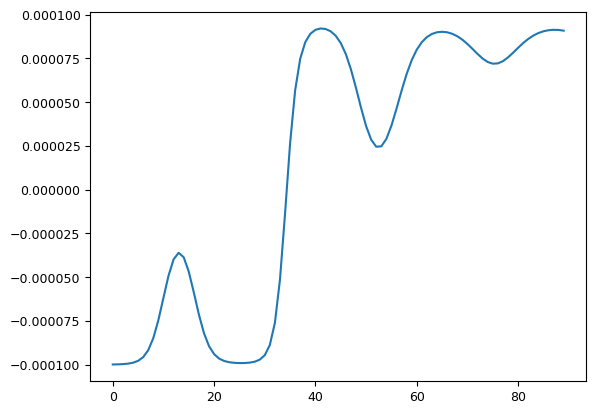

In [88]:
plt.plot(x_traj)

In [89]:
trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = len(x_traj)
x = x_traj
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
    # obj.SlewRateObjective(waveform, value=4e6, dt=trap.dt, constraint_type='<=')  # V/s
]

solver_results = solver(objectives, verbose=True, solver="ECOS")
waveform = solver_results.waveform.value  # get array from cvxpy variable

#savename = data_dir / 'waveform_transport.npy'
#print(f"Saving waveform as ndarray to {savename}")
#np.save(savename, waveform)


Compiling objectives:   0%|          | 0/274 [00:00<?, ?it/s]

Compiling objectives: 100%|██████████| 274/274 [00:00<00:00, 284.74it/s]


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 21 12:59:09 AM: Your problem has 1080 variables, 2160 constraints, and 0 parameters.
(CVXPY) Feb 21 12:59:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 21 12:59:09 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 21 12:59:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 21 12:59:09 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 21 12:59:09 AM: Compiling problem (target solver=ECOS).

/home/kallo27/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.525e-16  -6.300e+06  +4e+08  5e-02  1e-03  1e+00  8e+04    ---    ---    1  1  - |  -  - 
 1  -1.134e+06  -2.627e+06  +9e+07  1e-02  3e-04  6e+02  2e+04  0.7700  1e-02   1  1  1 |  0  0
 2  -3.067e+05  -4.647e+05  +1e+07  1e-03  3e-05  2e+02  2e+03  0.8987  5e-03   1  1  1 |  0  0
 3  -5.460e+05  -6.995e+05  +1e+07  1e-03  3e-05  3e+02  2e+03  0.0919  7e-01   1  1  1 |  0  0
 4  -2.566e+05  -3.029e+05  +3e+06  3e-04  9e-06  1e+02  6e+02  0.7238  4e-02   1  1  1 |  0  0
 5  -2.931e+05  -3.392e+05  +3e+06  3e-04  9e-06  1e+02  6e+02  0.0433  9e-01   1  1  1 |  0  0
 6  -4.765e+05  -4.943e+05  +1e+06  1e-04  3e-06  2e+02  2e+02  0.9890  4e-01   1  1  1 |  0  0
 7  -4.743e+05  -4.921e+05  +1e+06  1e-04  3e-06  2e+02  2e+02  0.0352  9e-01   1  1  2 |  0  0
 8  -2.466e+05  -2.567e+05  +6e+05  7e-05  2e

--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[90.8376  0.0002 67.0809]
Gradient [V/m]
[ 0.0632 -0.0037 -0.6417]
Displacement at 1 MHz [um]
[ 0.0039 -0.0002 -0.0392]
Hessian [V/m2]
[[ 1.6351e+07 -5.8654e+05 -4.2122e+05]
 [-5.8654e+05  6.2750e+08  8.0000e+07]
 [-4.2122e+05  8.0000e+07  5.6517e+08]]
Normal mode frequencies [MHz]
[0.999969 5.58744 6.45916]
Eigenvectors
[[1 0.000876 0.00064]
 [3.38e-05 0.564 -0.826]
 [-0.00108 0.826 0.564]]
Tilt angle of mode 2 (6.46): 34.36°

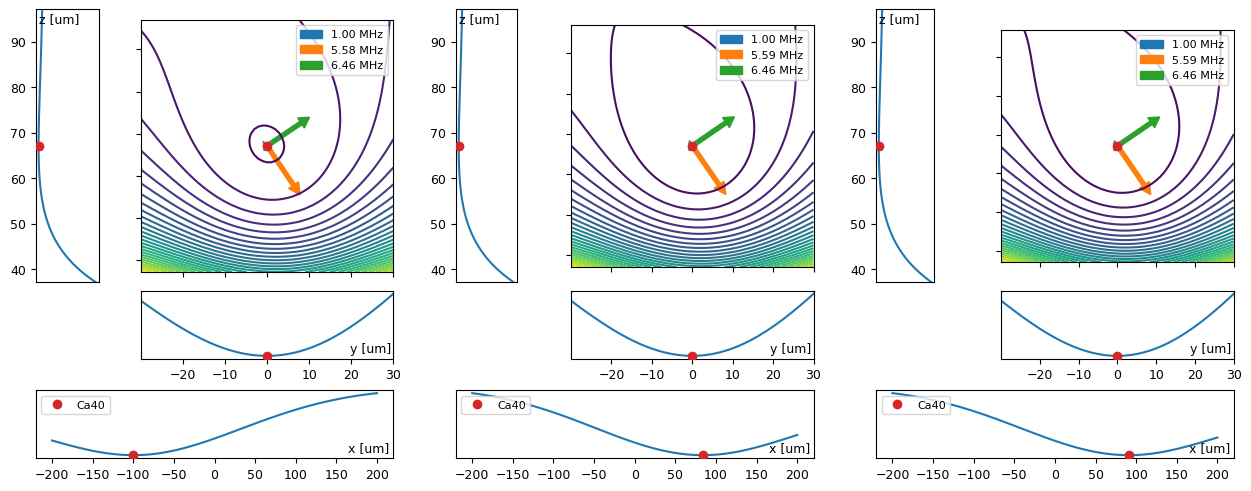

In [90]:
r0 = (0, 0, trap.z0)
roi = ((-200e-6, 200e-6), 30e-6, 30e-6)

from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout

fig, axes = plot_potential_make_layout(3)
res1 = analyse_potential(trap, voltages=waveform[0], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[0])
res1 = analyse_potential(trap, voltages=waveform[len(waveform) // 2], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[1])
res2 = analyse_potential(trap, voltages=waveform[-1], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[2])

res2

In [91]:
from pytrans.analysis import analyse_waveform
results = analyse_waveform(trap, waveform, ions=[Ca40, Ca40], ion1=Ca40, r0=r0, roi=roi)

Waveform analysis: 100%|██████████| 90/90 [00:10<00:00,  8.79it/s]


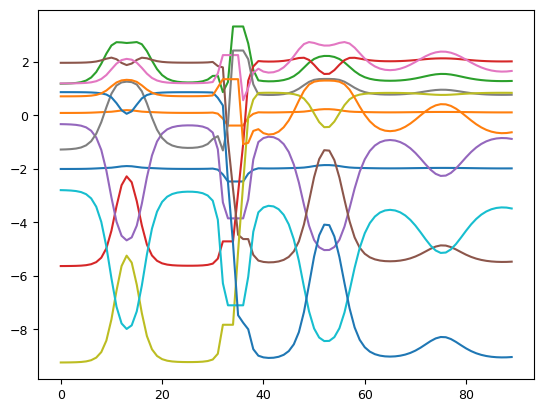

In [92]:
plt.plot(waveform)

In [93]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 10/2021
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

'''
Module docstring
'''
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt  # noqa

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from matplotlib.animation import FuncAnimation

import json
from pathlib import Path as pathlib_path


plt.rcParams['font.size'] = 9
electrodes_data = './surface_trap_geometry.json'

with open(electrodes_data, 'r') as f:
    electrodes = json.load(f)

all_patches = {}
for name, ele in electrodes.items():
    path = Path.make_compound_path(*[Path(ring) for ring in ele])
    patch = PathPatch(path)
    all_patches[name] = patch

labels_x = np.asarray(dc_edges).mean(axis=1) * 1e6
el_y = (rf_sep / 2 + rf_width) * 1e6
dy = 50

labels_positions = [(300, 50)] + [(300, -50)] + \
    [(labels_x[j], el_y + dy) for j in range(n_dc_lines)] + \
    [(labels_x[j], -el_y - dy) for j in range(n_dc_lines)]

# labels_positions = np.asarray([
#     (-dc_width / 2, el_y + dy),
#     (dc_width / 2, el_y + dy),
#     (-dc_width / 2, -el_y - dy),
#     (dc_width / 2, -el_y - dy),
# ]) * 1e6


def find_ylim(a, r=0.05):
    _min = np.min(a)
    _max = np.max(a)
    ptp = _max - _min
    return _min - r * ptp, _max + r * ptp


def make_plot_on_trap_layout(n: int = 1, fig=None, figsize1=(6, 3.2)):
    if fig is None:
        fig = plt.figure(figsize=(figsize1[0] * n, figsize1[1]), dpi=100)
    _subplots_kw = dict(nrows=2, ncols=1, sharex=True, gridspec_kw=dict(height_ratios=[0.5, 1], top=0.95, bottom=0.14))
    if n > 1:
        subfigs = fig.subfigures(1, n)
        axes = [subfigs[j].subplots(**_subplots_kw) for j in range(n)]
    else:
        axes = fig.subplots(**_subplots_kw)
    return fig, axes


def _setup_plot_on_trap(trap: SurfaceTrap, axes=None, vmin=-10, vmax=10, cmap='RdBu_r',
                        edgecolor='k', linewidth=0.5, fontsize=7, title=''):

    if axes is None:
        fig, axes = make_plot_on_trap_layout(1)
    else:
        fig = axes[0].figure

    fig.suptitle(title)
    ax0, ax = axes

    nv = trap.n_electrodes
    vzeros = np.zeros((nv,))

    # plot electrodes and voltages
    patches = [all_patches[name] for name in trap._all_electrodes]
    patches_blank = set(all_patches.values()) - set(patches)

    cmap = plt.colormaps[cmap]
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(vzeros))
    pc = PatchCollection(patches, facecolor=colors, edgecolor=edgecolor, linewidth=linewidth, cmap=cmap, norm=norm)
    ax.add_collection(pc)

    poss = [labels_positions[j] for j in trap.electrode_all_indices]
    labels = []
    if fontsize > 0:
        for pos in poss:
            tx = ax.text(*pos, f"{0:+.2f}", ha='center', va='center', fontsize=fontsize)
            labels.append(tx)

    pc_rf = PatchCollection(patches_blank, facecolor='none', edgecolor=edgecolor, linewidth=linewidth, cmap=cmap, norm=norm)
    ax.add_collection(pc_rf)

    ttime = ax.text(0.9, 0.85, '', transform=ax0.transAxes)

    ax.set(
        xlim=(-350, 350),
        ylim=(-400, 400),
        xticks=np.arange(-300, 301, 100),
        yticks=np.arange(-400, 401, 400),
        xlabel='x [um]',
        ylabel='y [um]',
        # aspect=1,
    )

    # plot potential
    p0 = np.zeros_like(trap.x)
    pot, = ax0.plot(trap.x * 1e6, p0)

    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.set(
        ylabel='$\\phi$ [eV]'
    )
    fig.align_ylabels()

    artists = (pc, pot, ttime, tuple(labels))
    return fig, axes, artists


def plot_voltages_on_trap(trap: SurfaceTrap, voltages: ArrayLike, axes=None, vmin=-10, vmax=10, cmap='RdBu_r',
                          edgecolor='k', linewidth=0.5, fontsize=7, title=''):

    fig, axes, artists = _setup_plot_on_trap(trap, axes, vmin, vmax, cmap,
                                             edgecolor, linewidth, fontsize, title)

    ax0, ax = axes
    pc, pot, ttime, labels = artists

    potential = trap.potential(voltages, trap.x, 0, trap.z0, 1, pseudo=False)
    cmap = plt.colormaps[cmap]
    norm = Normalize(vmin=vmin, vmax=vmax)

    colors = cmap(norm(voltages))
    pc.set_facecolor(colors)
    pot.set_ydata(potential)
    pot.axes.relim()
    pot.axes.autoscale_view()
    for volt, t in zip(voltages, labels):
        t.set_text(f"{volt:+.2f}")
        t.set_color('k' if abs(volt) < 8 else 'w')
    return fig, axes


def animate_waveform_on_trap(trap: SurfaceTrap, waveform: ArrayLike, axes=None, vmin=-10, vmax=10, cmap='RdBu_r',
                             edgecolor='k', linewidth=0.5, fontsize=7, title='',
                             frames=None, animate_kw=dict()):

    fig, axes, artists = _setup_plot_on_trap(trap, axes, vmin, vmax, cmap,
                                             edgecolor, linewidth, fontsize, title)
    ax0, ax = axes
    pc, pot, ttime, labels = artists

    potentials = trap.potential(waveform, trap.x, 0, trap.z0, 1, pseudo=False)
    cmap = plt.colormaps[cmap]
    norm = Normalize(vmin=vmin, vmax=vmax)

    def init():
        ax0.set_ylim(find_ylim(potentials))
        return (pc, pot, ttime,) + labels

    def update(j):
        colors = cmap(norm(waveform[j]))
        pc.set_facecolor(colors)
        pot.set_ydata(potentials[j])
        pot.axes.relim()
        pot.axes.autoscale_view()
        for v, t in zip(waveform[j], labels):
            t.set_text(f"{v:+.2f}")
            t.set_color('k' if abs(v) < 8 else 'w')
        ttime.set_text(str(j))
        return (pc, pot, ttime,) + labels

    kw = dict(blit=True, interval=20, repeat_delay=2000)
    kw.update(animate_kw)

    frames = range(len(waveform)) if frames is None else frames
    ani = FuncAnimation(fig, update, frames=frames,
                        init_func=init, **kw)
    return ani


#if __name__ == '__main__':
#    trap = SurfaceTrap()
#    plot_voltages_on_trap(trap, np.arange(trap.n_electrodes) - trap.n_electrodes / 2)
#    plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


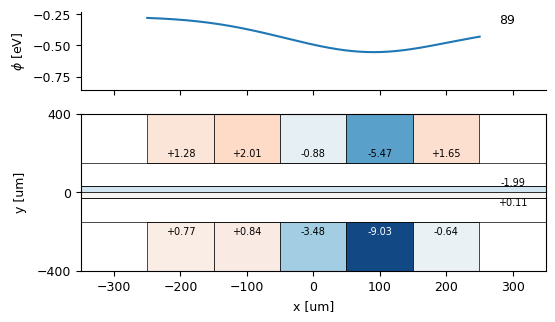

In [94]:
ani = animate_waveform_on_trap(trap, waveform)
ani.save('waveform_transport.gif', fps=10)

[]

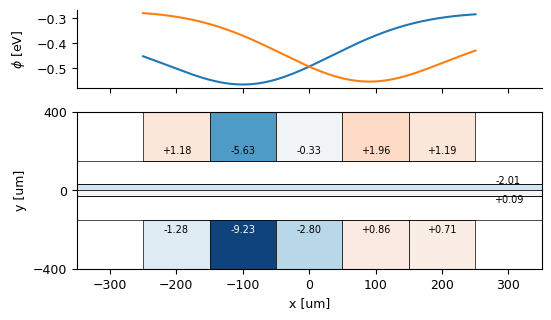

In [95]:
fig, (ax, ax0) = plot_voltages_on_trap(trap, waveform[0])
# _ = plot_voltages_on_trap(trap, waveform[-1])
x = trap.x
p = trap.potential(waveform[-1], x, 0, trap.z0, Ca40.mass_amu)
ax.plot(x*1e6, p)
ax.set(
    # xlim=(-450, 450)
)
